# Data Load

In [1]:
import pandas
import konlpy
import gensim
import os

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

In [4]:
label_counts = train_data['label'].value_counts(normalize=True) * 100
label_counts

0    50.115333
1    49.884667
Name: label, dtype: float64

In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
# 데이터셋 내 문장 길이 분석
total_data_text = list(X_train) + list(X_test)
# 문장 길이 리스트
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이 평균 및 최대, 표준편차 계산
print('문장 길이 평균 :', np.mean(num_tokens))
print('문장 길이 최대 :', np.max(num_tokens))
print('문장 길이 표준편차 :', np.std(num_tokens))

# 적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen :', maxlen)
print('전체 문장의 {:.2f}%가 maxlen 이내에 포함됩니다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100))


문장 길이 평균 : 15.96940191154864
문장 길이 최대 : 116
문장 길이 표준편차 : 12.843571191092
pad_sequences maxlen : 41
전체 문장의 93.43%가 maxlen 이내에 포함됩니다.


In [10]:
# 패딩 추가
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')  # 뒤쪽(padding='post')으로 0을 채움
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')

# 패딩된 결과 확인
print(X_train.shape)

(146182, 41)


# Modeling

## LSTM (Long Short-Term Memory)

In [11]:
import tensorflow as tf

vocab_size = 10000
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,017,569
Trainable params: 1,017,569
Non-trainable params: 0
_________________________________________________________________


In [12]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [13]:
# 조기 종료 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, 
    verbose=1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping]) 

Epoch 1/20
266/266 [==============================] - 29s 8ms/step - loss: 0.4703 - accuracy: 0.7511 - val_loss: 0.3492 - val_accuracy: 0.8478
Epoch 2/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3290 - accuracy: 0.8577 - val_loss: 0.3390 - val_accuracy: 0.8512
Epoch 3/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3010 - accuracy: 0.8699 - val_loss: 0.3314 - val_accuracy: 0.8575
Epoch 4/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2746 - accuracy: 0.8807 - val_loss: 0.3320 - val_accuracy: 0.8580
Epoch 5/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2520 - accuracy: 0.8925 - val_loss: 0.3445 - val_accuracy: 0.8574
Epoch 6/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2306 - accuracy: 0.9022 - val_loss: 0.3587 - val_accuracy: 0.8567
Epoch 7/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2136 - accuracy: 0.9108 - val_loss: 0.3870 - val_accuracy: 0.8538
Epoch

In [14]:
lstm_results = model.evaluate(X_test,  y_test, verbose=2)

print(lstm_results)

1537/1537 - 3s - loss: 0.4079 - accuracy: 0.8478
[0.40787532925605774, 0.8477734327316284]


In [15]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


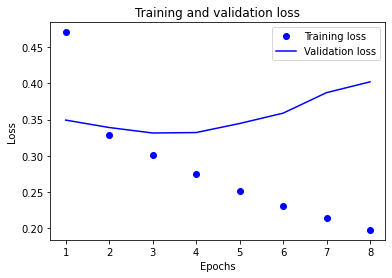

In [16]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

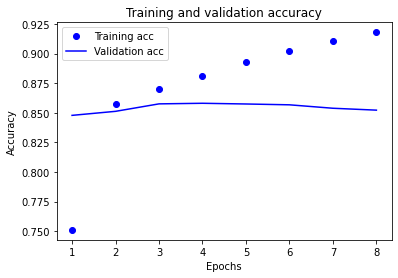

In [17]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


### Embedding Layer Analysis

In [19]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [20]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
import os 
word_vector_dim = 100


word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/rnn_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [21]:
#Genism 패키지를 활용해, 임베딩 파라미터를 읽어 word vector로 활용 
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([ 0.08482736, -0.00886417, -0.10825478,  0.00926631,  0.08267232,
        0.05456342, -0.04743546,  0.03414231,  0.08921476,  0.07407016,
       -0.08100463, -0.08843101,  0.06734482, -0.13221931, -0.04418904,
       -0.12169836, -0.12519206, -0.05979775, -0.11045902,  0.12594387,
       -0.04990293, -0.09094889, -0.10365181,  0.10349414, -0.12719664,
        0.05059938, -0.06694915,  0.1381287 , -0.02819969,  0.06705128,
       -0.06426802, -0.0964954 ,  0.12793241, -0.07672648, -0.0738093 ,
       -0.05560882, -0.00945888, -0.03499731, -0.10989644,  0.0396699 ,
        0.1093066 , -0.10692374,  0.05584301, -0.03194629,  0.03426806,
        0.08326257, -0.01347605, -0.04768985,  0.10780186, -0.09741209,
       -0.1202023 , -0.10037304, -0.09973544,  0.1361097 , -0.09893439,
        0.1988649 ,  0.02410872,  0.16460444,  0.07702813, -0.10570487,
       -0.08032321,  0.06591666,  0.14171559, -0.05732272, -0.07234392,
       -0.05554694, -0.1186756 ,  0.08356397, -0.0178062 , -0.11

In [22]:
word_vectors.similar_by_word("감동")

[('면모', 0.8991584777832031),
 ('케미', 0.8952021598815918),
 ('돌아볼', 0.892147421836853),
 ('잴', 0.8783643245697021),
 ('해집니다', 0.8757500648498535),
 ('며느리', 0.874458372592926),
 ('최강희', 0.8743633031845093),
 ('역작', 0.8741792440414429),
 ('싱크로', 0.869109570980072),
 ('어울려요', 0.8683589100837708)]

## 1D-CNN

In [23]:
# 1D-CNN
vocab_size = 1000
word_vector_dim = 32

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [24]:
# 조기 종료 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping]) 

Epoch 1/20
266/266 [==============================] - 17s 6ms/step - loss: 0.5732 - accuracy: 0.7306 - val_loss: 0.4991 - val_accuracy: 0.8183
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4833 - accuracy: 0.8187 - val_loss: 0.4629 - val_accuracy: 0.8262
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4455 - accuracy: 0.8311 - val_loss: 0.4375 - val_accuracy: 0.8293
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4135 - accuracy: 0.8416 - val_loss: 0.4188 - val_accuracy: 0.8320
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3855 - accuracy: 0.8522 - val_loss: 0.4108 - val_accuracy: 0.8337
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3608 - accuracy: 0.8616 - val_loss: 0.4102 - val_accuracy: 0.8278
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3399 - accuracy: 0.8706 - val_loss: 0.4117 - val_accuracy: 0.8293
Epoch

In [25]:
cnn_results = model.evaluate(X_test,  y_test, verbose=2)

print(cnn_results)

1537/1537 - 3s - loss: 0.4609 - accuracy: 0.8172
[0.46094462275505066, 0.8171775937080383]


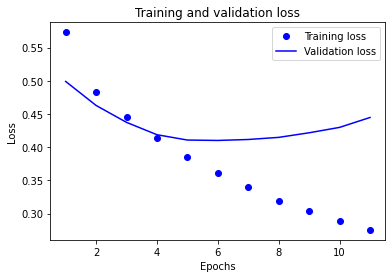

In [26]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

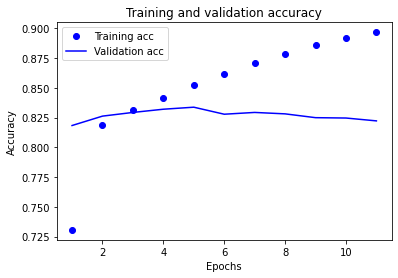

In [27]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Transformer

In [28]:
vocab_size = 10000
word_vector_dim = 100

# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cos 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 트랜스포머 인코더 레이어
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 어텐션 및 피드포워드 네트워크
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # 피드 포워드 네트워크
    ff = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation="relu"),
        tf.keras.layers.Dense(inputs.shape[-1]),
    ])
    ff_output = ff(x)
    ff_output = tf.keras.layers.Dropout(dropout)(ff_output)
    output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff_output)
    return output

# 모델 구성
inputs = tf.keras.Input(shape=(None,), dtype=tf.int64)
embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim)(inputs)
pos_encoding = PositionalEncoding(500, word_vector_dim)(embedding_layer)
x = transformer_encoder(pos_encoding, word_vector_dim, 2, word_vector_dim)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    1000000     input_1[0][0]                    
__________________________________________________________________________________________________
positional_encoding (Positional (None, None, 100)    0           embedding_2[0][0]                
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, None, 100)    80700       positional_encoding[0][0]        
                                                                 positional_encoding[0][0]    

In [29]:
# 조기 종료 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping]) 

Epoch 1/20
266/266 [==============================] - 7s 21ms/step - loss: 0.4797 - accuracy: 0.7453 - val_loss: 0.3445 - val_accuracy: 0.8494
Epoch 2/20
266/266 [==============================] - 5s 20ms/step - loss: 0.3300 - accuracy: 0.8569 - val_loss: 0.3326 - val_accuracy: 0.8520
Epoch 3/20
266/266 [==============================] - 5s 20ms/step - loss: 0.2992 - accuracy: 0.8730 - val_loss: 0.3419 - val_accuracy: 0.8545
Epoch 4/20
266/266 [==============================] - 5s 20ms/step - loss: 0.2836 - accuracy: 0.8799 - val_loss: 0.3495 - val_accuracy: 0.8482
Epoch 5/20
266/266 [==============================] - 5s 20ms/step - loss: 0.2697 - accuracy: 0.8864 - val_loss: 0.3545 - val_accuracy: 0.8442
Epoch 6/20
266/266 [==============================] - 5s 20ms/step - loss: 0.2624 - accuracy: 0.8902 - val_loss: 0.3542 - val_accuracy: 0.8461
Epoch 7/20
266/266 [==============================] - 5s 20ms/step - loss: 0.2533 - accuracy: 0.8948 - val_loss: 0.3795 - val_accuracy: 0.8407

In [30]:
transformer_results = model.evaluate(X_test,  y_test, verbose=2)

print(transformer_results)

1537/1537 - 4s - loss: 0.3811 - accuracy: 0.8411
[0.3811083436012268, 0.8410602807998657]


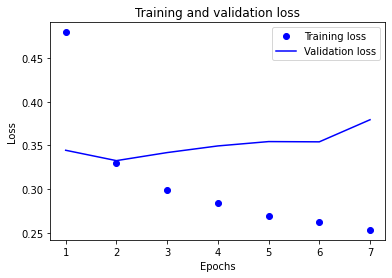

In [31]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

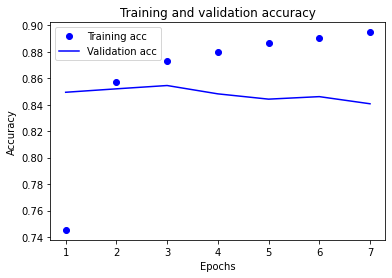

In [32]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Word2Vec CNN

In [33]:
from gensim.models import KeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'

from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [34]:
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [50]:
word_vectors.wv.similar_by_word("감동")

[('감격', 0.8046045899391174),
 ('감탄', 0.7326707243919373),
 ('매혹', 0.7267226576805115),
 ('매력', 0.7088802456855774),
 ('감명', 0.7069407105445862),
 ('웃음', 0.7015025615692139),
 ('열정', 0.6936471462249756),
 ('칭찬', 0.6831857562065125),
 ('실망', 0.6779423952102661),
 ('슬픔', 0.6770600080490112)]

In [51]:
vocab_size = 10000   
word_vector_dim = 100 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [52]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [53]:
# 조기 종료 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])  

Epoch 1/20
266/266 [==============================] - 2s 6ms/step - loss: 0.6131 - accuracy: 0.6496 - val_loss: 0.5110 - val_accuracy: 0.7552
Epoch 2/20
266/266 [==============================] - 1s 6ms/step - loss: 0.4563 - accuracy: 0.7872 - val_loss: 0.4285 - val_accuracy: 0.8029
Epoch 3/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3900 - accuracy: 0.8266 - val_loss: 0.3861 - val_accuracy: 0.8237
Epoch 4/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3502 - accuracy: 0.8474 - val_loss: 0.3691 - val_accuracy: 0.8359
Epoch 5/20
266/266 [==============================] - 1s 6ms/step - loss: 0.3228 - accuracy: 0.8615 - val_loss: 0.3581 - val_accuracy: 0.8407
Epoch 6/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3046 - accuracy: 0.8710 - val_loss: 0.3595 - val_accuracy: 0.8396
Epoch 7/20
266/266 [==============================] - 1s 6ms/step - loss: 0.2878 - accuracy: 0.8787 - val_loss: 0.3560 - val_accuracy: 0.8445
Epoch 

In [54]:
w2v_cnn_results = model.evaluate(X_test,  y_test, verbose=2)
print(w2v_cnn_results)

1537/1537 - 3s - loss: 0.4182 - accuracy: 0.8386
[0.4182074964046478, 0.8385987877845764]


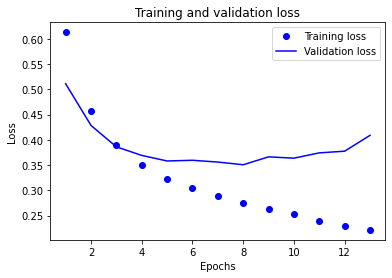

In [55]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

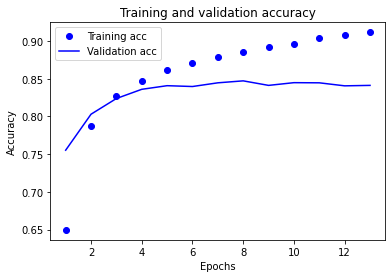

In [56]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## word2vector LSTM

In [57]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 1,017,569
Trainable params: 1,017,569
Non-trainable params: 0
_________________________________________________________________


In [58]:
# 조기 종료 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping]) 

Epoch 1/20
266/266 [==============================] - 4s 8ms/step - loss: 0.5948 - accuracy: 0.6493 - val_loss: 0.4607 - val_accuracy: 0.7925
Epoch 2/20
266/266 [==============================] - 2s 6ms/step - loss: 0.4031 - accuracy: 0.8200 - val_loss: 0.3726 - val_accuracy: 0.8356
Epoch 3/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3453 - accuracy: 0.8501 - val_loss: 0.3461 - val_accuracy: 0.8491
Epoch 4/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3204 - accuracy: 0.8626 - val_loss: 0.3392 - val_accuracy: 0.8521
Epoch 5/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2993 - accuracy: 0.8734 - val_loss: 0.3350 - val_accuracy: 0.8533
Epoch 6/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2836 - accuracy: 0.8811 - val_loss: 0.3335 - val_accuracy: 0.8557
Epoch 7/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2724 - accuracy: 0.8866 - val_loss: 0.3393 - val_accuracy: 0.8545
Epoch 

In [59]:
w2v_lstm_results = model.evaluate(X_test,  y_test, verbose=2)

print(w2v_lstm_results)

1537/1537 - 3s - loss: 0.3602 - accuracy: 0.8513
[0.3602382242679596, 0.8512521386146545]


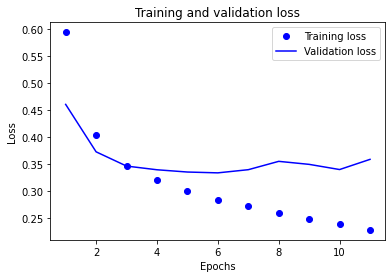

In [60]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

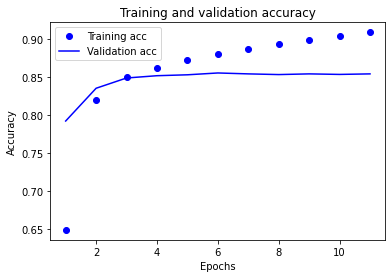

In [61]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Retrospective

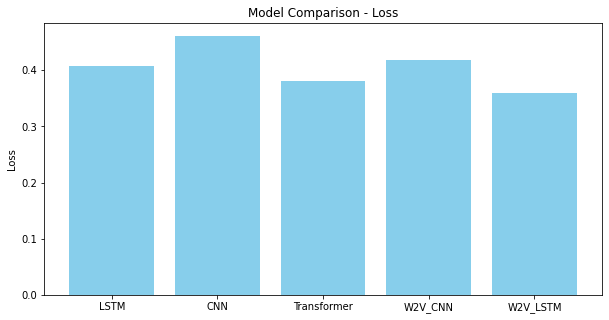

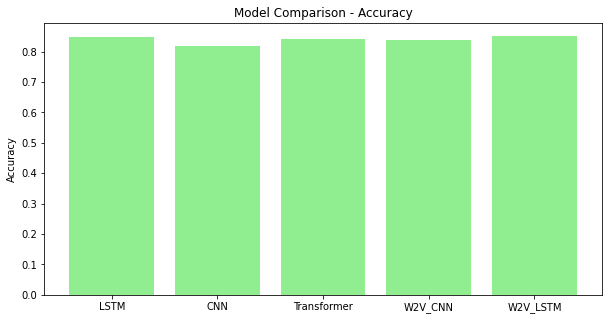

In [62]:
# 결과 리스트
results = [lstm_results, cnn_results, transformer_results, w2v_cnn_results, w2v_lstm_results]
labels = ['LSTM', 'CNN', 'Transformer', 'W2V_CNN', 'W2V_LSTM']

# 손실 그래프
loss_values = [result[0] for result in results]
plt.figure(figsize=(10, 5))
plt.bar(labels, loss_values, color='skyblue')
plt.title('Model Comparison - Loss')
plt.ylabel('Loss')
plt.show()

# 정확도 그래프
accuracy_values = [result[1] for result in results]
plt.figure(figsize=(10, 5))
plt.bar(labels, accuracy_values, color='lightgreen')
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.show()

동일한 vocab_size와 word_vector_dim로 고정한 뒤 기본적인 구성으로 다양한 모델을 비교해보았는데 모두 큰차이 없는 비슷한 성능을 보여주었다.<br/>
학습 중 val_loss를 확인하였을 때 모든 모델이 과적합 문제가 발생했기 때문일 수 있지만 dropout과 모델 구조를 최대한 단순하게 조정 후 <br/>
Word2Vec를 적용했을 때 85점으로 가장 높은 성능을 보여주었지만 다른 모델들과 큰 성능차이를 보여주지 못한 것으로 보여 학습 데이터가 부족한 것이 아닐까 생각했다.<br/>
word_vectors similar by word를 확인하였을 때는 적용 전과 후의 명확한 유사성 차이가 나타난 것을 확인할 수 있었다.
<br/>
<br/>
단순한 이진 분류 모델이지만 데이터 불균형이 없는 데이터로 학습이 잘 이루어지지 않았음에도 85점대의 높은 성능을 보여주어
제대로 학습이 되었을 경우 정말 높은 정확도를 예측할 것으로 예상된다.<br/>
<br/>
Transformer 모델은 가장 단순한 구성으로 사용해보았는데 아직 구성이 원리를 이해하지 못해 더 찾아가며 공부해야할 것 같다.